In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk

Toto cvičení se věnuje zpracování zvuku, jeho spektrální analýze a filtraci. Jeho obsahem bude:
* načtení a zobrazení wavky
* výpočet a zobrazení spektra a spektrogramu
* zadání filtru, zobrazení jeho impulsní odezvy, frekvenční charakteristiky, nul a pólů, zhodnocení stability a samotná filtrace signálu
* ukázka třetino-oktávového ekvalizéru

# Načtení a základní analýza

Budeme pracovat s nahrávkou `music.wav` se vzorkovací frekvencí $F_s = 44100\ Hz$ (44100 vzorků odpovídá jedné sekundě). Z nahrávky budeme používat pouze prvních 250000 vzorků (cca 5.5 sekund). Pro načtení wav souboru využijeme knihovnu `soundfile`.

In [3]:
s, fs = sf.read('music.wav')
s = s[:250000]
t = np.arange(s.size) / fs

<IPython.core.display.Javascript object>


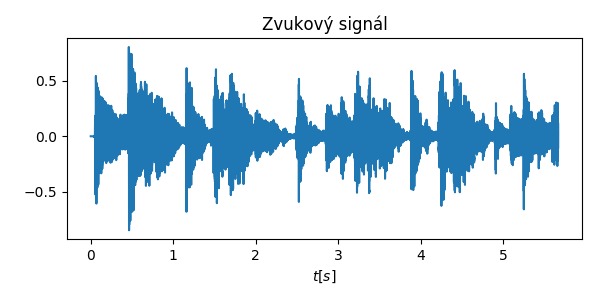

In [4]:
plt.figure(figsize=(6,3))
plt.plot(t, s)

# plt.gca() vraci handle na aktualni Axes objekt, 
# ktery nam umozni kontrolovat ruzne vlastnosti aktualniho grafu
# napr. popisy os
# viz https://matplotlib.org/users/pyplot_tutorial.html#working-with-multiple-figures-and-axes
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')

plt.tight_layout()

In [5]:
# prehrani v notebooku obcas blbne, zobrazuje spatnou nebo i nulovou
# delku wavky, doporucuju v takovem priprade bunku nebo cely notebook restartovat,
# v nejhorsim zvuk ulozit do souboru a prehrat mimo notebook
# sf.write('new_file.wav', s, fs)
IPython.display.display(IPython.display.Audio(s, rate=fs))

## Jedno spektrum

Zvukový signál budeme chtít frekvenčně analyzovat - převést na spektrum, které nám ukáže jaké frekvence signál obsahuje a jak moc. Frekvenční analýzu budeme provádět pomocí diskrétní Fourierovy transformace (DFT), přesněji řečeno rychlé Fourierovy transformace (FFT), což je rychlejší algoritmus pro spočítání DFT.

DFT zpracovává N vzorků signálu a vrací $N$ vzorků spektra, které odpovídají frekvencním 0 až ''skoro'' $F_s$ (vzorek $N$ by odpovídal přesně $F_s$, tady dostaneme vzorky $0\dots N-1$ odpovídající $0\dots \frac{N-1}{N} F_s$). Ze spektra zobrazujeme jen jeho první půlku (vzorky $0\dots N/2$), druhá půlka je symetrická kvůli aliasingu.

Při zpracování zvuku budeme zobrazovat tzv. logaritmickou spektrální hustotu výkonu $G[k]$ (power spectral density - PSD). Spektrální hustota výkonu udává energii signálu na dané frekvenci. Transformace logaritmem se používá, protože výsledek lépe odpovídá lidskému slyšení (https://acousticstoday.org/the-world-through-sound-decibels/). 

$$
G[k] = 10 \log_{10} \frac{|X[k]|^2}{N} 
$$

Spektrum nebudeme počítat pro celý signál naráz, protože signál a jeho frekvenční obsah se v průběhu mění. V této části tedy vysekneme ze signálu jeden 20 ms segment, který budeme analyzovat.

In [6]:
odkud = 2     # začátek segmentu v sekundách
kolik = 0.02  # délka segmentu v sekundách

In [7]:
odkud_vzorky = int(odkud * fs)         # začátek segmentu ve vzorcích
pokud_vzorky = int((odkud+kolik) * fs) # konec segmentu ve vzorcích

s_seg = s[odkud_vzorky:pokud_vzorky]
N = s_seg.size

s_seg_spec = np.fft.fft(s_seg)
G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)

<IPython.core.display.Javascript object>


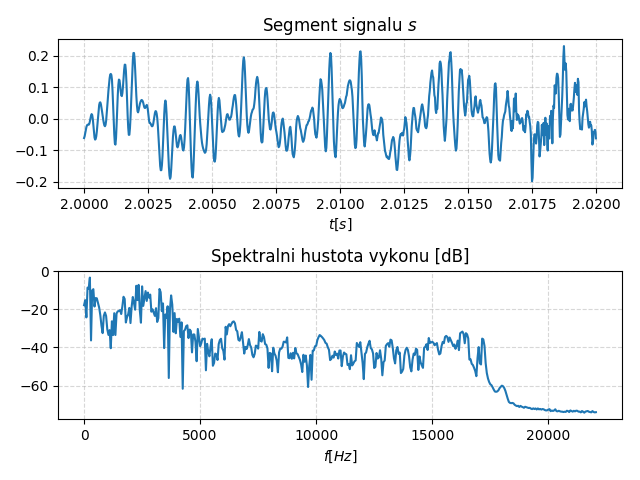

In [8]:
_, ax = plt.subplots(2,1)

# np.arange(n) vytváří pole 0..n-1 podobně jako obyč Pythonovský range
ax[0].plot(np.arange(s_seg.size) / fs + odkud, s_seg)
ax[0].set_xlabel('$t[s]$')
ax[0].set_title('Segment signalu $s$')
ax[0].grid(alpha=0.5, linestyle='--')

f = np.arange(G.size) / N * fs
# zobrazujeme prvni pulku spektra
ax[1].plot(f[:f.size//2+1], G[:G.size//2+1])
ax[1].set_xlabel('$f[Hz]$')
ax[1].set_title('Spektralni hustota vykonu [dB]')
ax[1].grid(alpha=0.5, linestyle='--')

plt.tight_layout()

## Spektrogram

Výše jsme analyzovali pouze jeden 20 ms segment zvuku. Často nás ale bude zajímat, jak se spektrum vyvíjí během celého signálu. Toto můžeme zjistit pomocí spektrogramu, který zobrazí závislost spektra na čase. Spektrogram můžeme získat tak, že signál rozdělíme na krátké segmenty, pro každý z nich spočítáme spektrum a zobrazíme do matice s časem na vodorovné ose a frekvencí na svislé ose. Jeden sloupec této matice tedy odpovídá spektru jednoho časového segmentu. Jeden řádek odpovídá vývoji energie na dané frekvenci přes čas. V Pythonu můžeme spektrogram získat pomocí ` scipy.signal.spectrogram`.

In [9]:
f, t, sgr = spectrogram(s, fs)
# prevod na PSD
# (ve spektrogramu se obcas objevuji nuly, ktere se nelibi logaritmu, proto +1e-20)
sgr_log = 10 * np.log10(sgr+1e-20) 

<IPython.core.display.Javascript object>


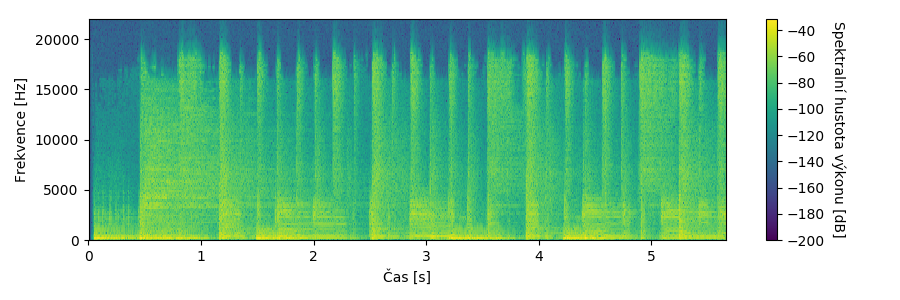

In [10]:
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

# Filtrace

V další části budeme signál filtrovat. Vyzkoušíme tři různé filtry:
1. jednoduchou dolní propusť - filtr, který zvýrazní nízké frekvence a oslabí vysoké
2. ostrou pásmovou propusť - filtr, zvýrazňující velmi úzký interval frekvencí
3. nestabilní filtr - filtr velmi podobný na 2., ale navržený tak, aby byl nestabilní

Všechny filtry budeme zadávat pomocí jejich koeficientů $a$, $b$, které určují diferenční rovnici filtru

$$
y[n] = \sum_{k=0}^{Q} b_k x[n-k] - \sum_{k=1}^{P} a_k y[n-k], 
$$

kde $y$ je výstupní signál a $x$ vstupní signál.

U každého filtru si zobrazíme jeho impulsní odezvu, frekvenční charakteristiku, nuly a póly. Podle polohy pólů navíc zhodnotíme stabilitu filtru a nakonec provedeme samotnou filtraci našeho signálu.

_Impulsní odezva_ filtru $h[n]$ je reakce filtru na jednotkový impuls, dává nám informaci o chování filtru v čase. V Pythonu ji získáme přímo vytvořením jednotkového impulsu a jeho vyfiltrováním (k tomu použijeme funkci `scipy.signal.lfilter`).

_Frekvenční charakteristika_ filtru $H(e^{j\omega})$ ukazuje chování filtru pro jednotlivé frekvenční složky obsažené v signále. Můžeme z ní tedy vyčíst, které frekvence filtr posiluje nebo které naopak potlačuje. V Pythonu k jejímu získání použijeme funkci `scipy.signal.freqz`. Protože frekvenční charakteristika je komplexní funkce, budeme ji zobrazovat zvlášť jako její modul (magnitudu) a argument (fázi). Z magnitudy můžeme vyčíst, jak filtr různé frekvenční složky v signále posílí/potlačí, z argumentu, jak se jednotlivé frekvenční složky zpozdí/předběhnou.

_Nuly a póly_ filtru jsou body v komplexní rovině $z$, která tvoří definiční obor přenosové funkce filtru $H(z)$. Přenosová funkce je zobecnění frekvenční charakteristiky - zatímco frekvenční charakteristika je definovaná pouze pro hodnoty $e^{j\omega}$, kde $\omega$ je kruhová frekvence, přenosová funkce je definovaná pro jakékoli komplexní číslo $z$. Obecně má přenosová funkce tvar

$$
H(z) = \frac{\sum_{k=0}^{Q} b_k z^{-k}}{1+
\sum_{k=1}^{P} a_k z^{-k}}.
$$

Dosazením $e^{j\omega}$ za $z$ bychom z přenosové funkce mohli vyčíst frekvenční charakteristiku filtru. Pro nás jsou v tuhle chvíli důležité nuly a póly přenosové funkce - nuly jsou takové hodnoty $z$, pro které je přenosová funkce nulová (tzn. její čitatel je roven 0), póly jsou takové hodnoty $z$, pro které je přenosová funkce nekonečná (tzn. její jmenovatel je roven 0). V Pythonu můžeme nuly a póly filtru získat pomocí funkce `scipy.signal.tf2zpk`.

Pomocí polohy pólů můžeme zhodnotit stabilitu filtru. Pokud je filtr stabilní, generuje pro omezené vstupy omezené výstupy (omezený $==$ omezený zhora/zdola, jeho hodnoty neutíkají do $\infty$ ani $-\infty$). Platí, že stabilní filtr má všechny póly uvnitř jednotkové kružnice, neboli

$$
|p_k| < 1 ~~~ \forall k,
$$

v opačném případě je filtr nestabilní.

Nakonec, samotnou filtraci našeho signálu pomocí filtru zadaného koeficienty $b$,$a$ v Pythonu provedeme pomocí funkce `scipy.signal.lfilter`.

## Několik příkladů filtrace

### 1. Jednoduchá dolní propusť

In [11]:
b = [0.2, 0.2, 0.2, 0.2, 0.2]
a = [1, 0, 0, 0, 0]

In [12]:
# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)] # jednotkovy impuls
h = lfilter(b, a, imp)

# frekvencni charakteristika
w, H = freqz(b, a)

# nuly, poly
z, p, k = tf2zpk(b, a)

# stabilita
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 

# filtrace
sf = lfilter(b, a, s)
f, t, sfgr = spectrogram(sf, fs)
sfgr_log = 10 * np.log10(sfgr+1e-20)

<IPython.core.display.Javascript object>


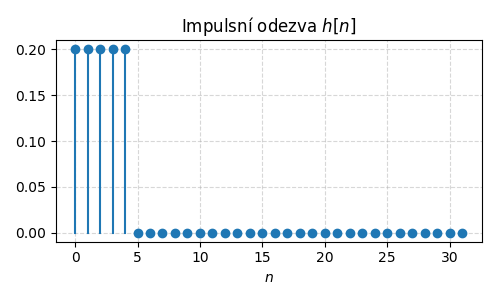

In [13]:
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


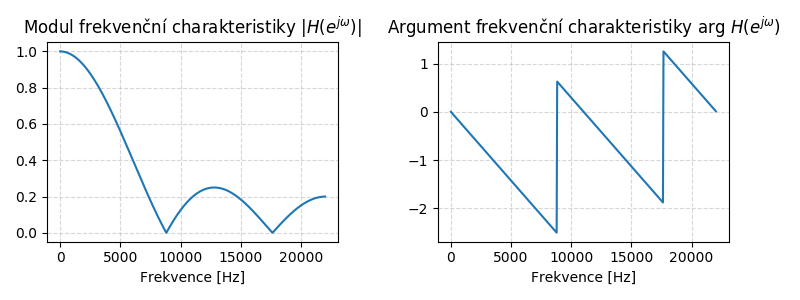

In [14]:
_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


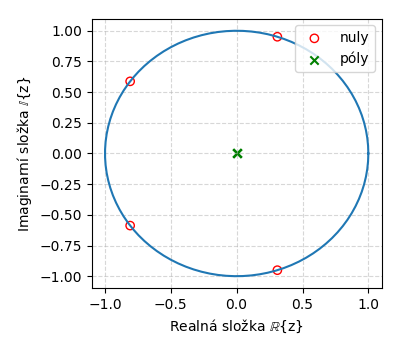

In [15]:
plt.figure(figsize=(4,3.5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper right')

plt.tight_layout()

In [16]:
print('Filtr {} stabilní.'.format('je' if is_stable else 'není'))

Filtr je stabilní.


<IPython.core.display.Javascript object>


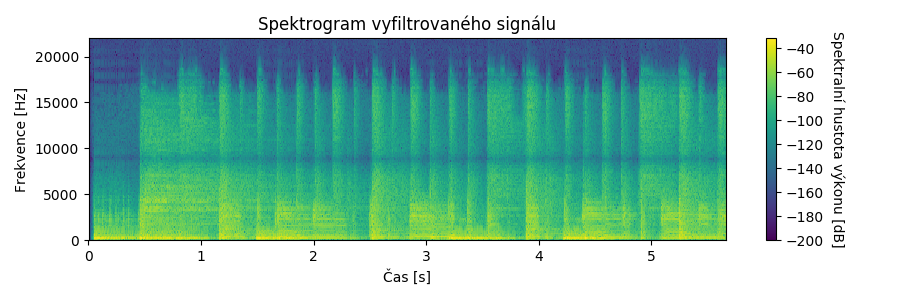

In [17]:
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sfgr_log)
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

### 2. Ostrá pásmová propusť

In [18]:
b = [1, 0, 0]
a = [1, -1.6808, 0.998]

In [19]:
# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)]
h = lfilter(b, a, imp)

# frekvencni charakteristika
w, H = freqz(b, a)

# nuly, poly
z, p, k = tf2zpk(b, a)

# stabilita
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 

# filtrace
sf = lfilter(b, a, s)
f, t, sfgr = spectrogram(sf, fs)
sfgr_log = 10 * np.log10(sfgr+1e-20)

<IPython.core.display.Javascript object>


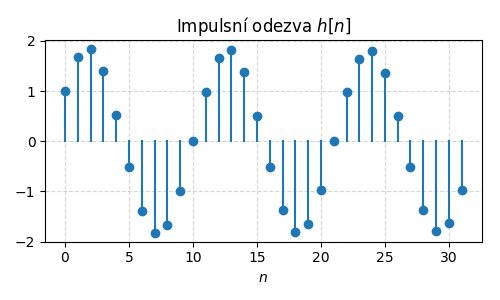

In [20]:
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


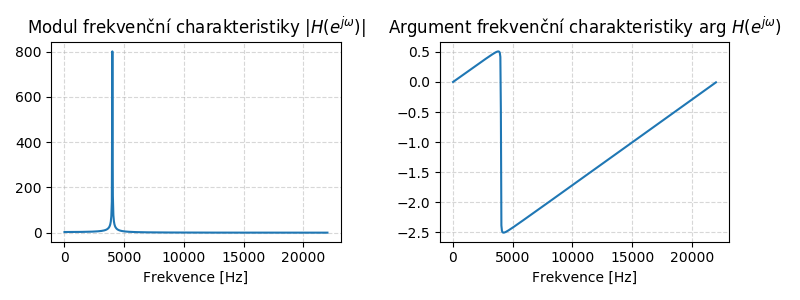

In [21]:
_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


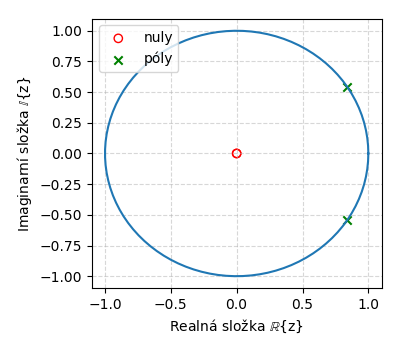

In [22]:
plt.figure(figsize=(4,3.5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

In [23]:
print('Filtr {} stabilni.'.format('je' if is_stable else 'není'))

Filtr je stabilni.


<IPython.core.display.Javascript object>


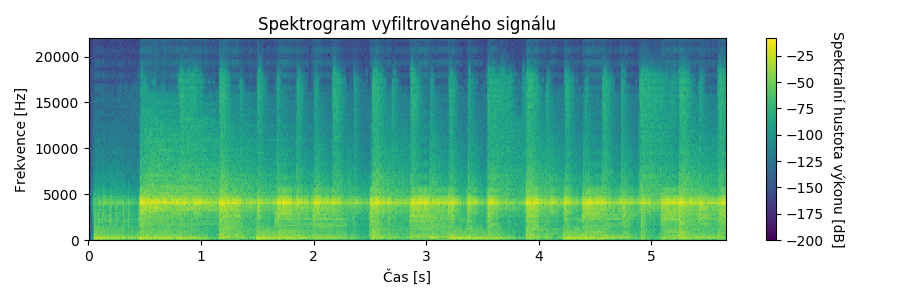

In [24]:
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sfgr_log)
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

### 3. Nestabilní filtr

In [25]:
b = [1, 0, 0]
a = [1, -1.684, 1.002]

In [26]:
# impulsni odezva
N_imp = 32
imp = [1, *np.zeros(N_imp-1)]
h = lfilter(b, a, imp)

# frekvencni charakteristika
w, H = freqz(b, a)

# nuly, poly
z, p, k = tf2zpk(b, a)

# stabilita
is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 

# filtrace
sf = lfilter(b, a, s)
f, t, sfgr = spectrogram(sf, fs)
sfgr_log = 10 * np.log10(sfgr+1e-20)

<IPython.core.display.Javascript object>


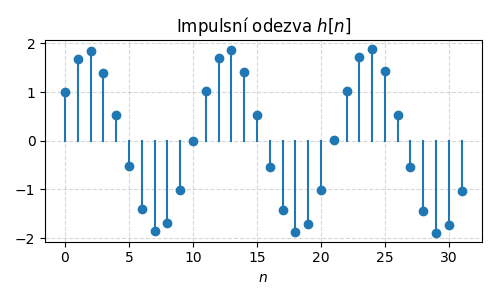

In [27]:
plt.figure(figsize=(5,3))
plt.stem(np.arange(N_imp), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')

plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


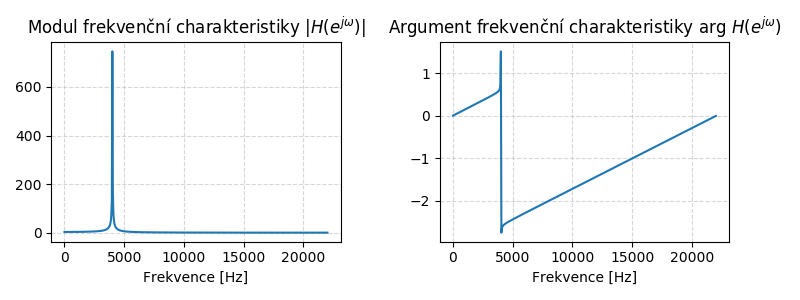

In [28]:
_, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


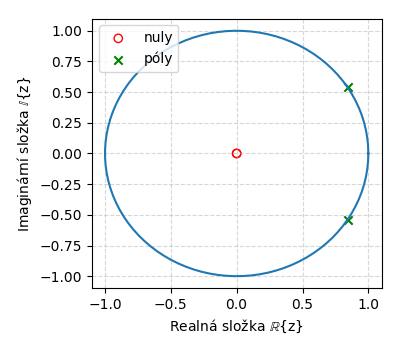

In [29]:
plt.figure(figsize=(4,3.5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

In [30]:
print('Filtr {} stabilni.'.format('je' if is_stable else 'není'))

Filtr není stabilni.


<IPython.core.display.Javascript object>


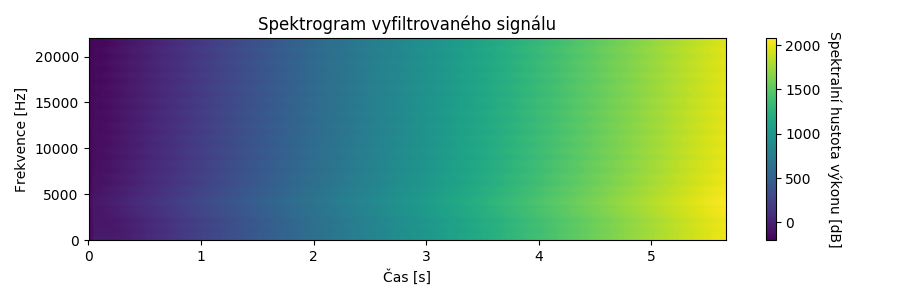

In [31]:
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sfgr_log)
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

## Třetino-oktávový ekvalizér

Na koncertě jste jistě viděli pana zvukaře s rackem plným elektroniky. Klíčovým elementem tam  byl  třetino-oktávový
ekvalizér, kterým se dá vyrovnat akustika místnosti, zlepšit zvuk nástrojů, atd. My si jej dnes  naimplementujeme. Ekvalizér obsahuje 23 filtrů, které jsou navrženy podle článku: 
Christophe Couvreur: ''Implementation of a One-Third-Octave Filter in
Matlab Bank'', k disposici na http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.57.5728 Matlabové kódy k němu můžete najít na http://kom.aau.dk/group/06gr943/thesis/octave/

My máme banku filtru již navrženou - koeficienty $a_i$ a $b_i$ filtru jsou uloženy v řádcích matic `Amat` a `Bmat` v souboru `filterbank.npz`.

In [32]:
data = np.load('filterbank.npz')
Amat, Bmat = data['Amat'], data['Bmat']

In [33]:
# vypocet frekvencnich charakteristik vsech filtru
# a ulozeni jejich modulu do matice H_all
H_all_stack = []
for i in range(Amat.shape[0]):
    w, H = freqz(Bmat[i,:], Amat[i,:], 2048)
    H_all_stack.append(np.abs(H))
    
H_all = np.array(H_all_stack)

<IPython.core.display.Javascript object>


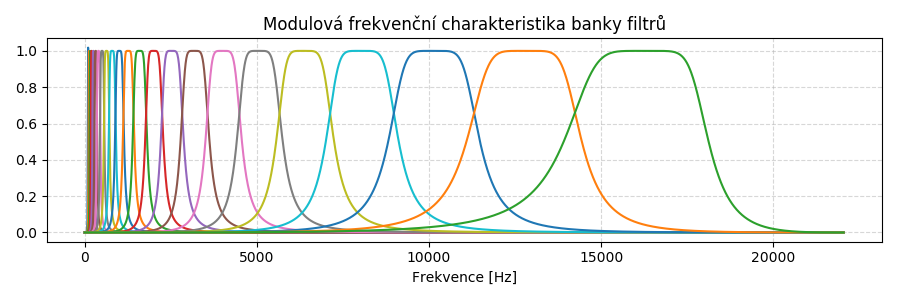

In [34]:
plt.figure(figsize=(9,3))
plt.plot(w / 2 / np.pi * fs, H_all.T)

plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title('Modulová frekvenční charakteristika banky filtrů')

plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

Signál zkusíme filtrovat do jednotlivých pásem a pak jej zase
složit. Výsledek by měl být zhruba ekvivalentní originálu. Každý z filtrů můžete zkusit analyzovat podobným způsobem jako výše (zobrazení impulsní odezvy, frekvenční charakteristiky, nul a pólů). Stejně tak si můžete zkusit výsledné signály zobrazit ve spektru.

In [35]:
out = np.zeros(s.shape)

for i, h in enumerate(H_all):
    s_filt = lfilter(Bmat[i,:], Amat[i,:], s)
    out += s_filt

In [36]:
# puvodni signal
IPython.display.display(IPython.display.Audio(s, rate=fs))
# signal rekonstruovany pres banku filtru
IPython.display.display(IPython.display.Audio(out, rate=fs))

S ekvalizérem si můžeme pohrát - třeba nechat jen basy a výšky.

In [37]:
# koeficienty pro jednotlive filtry
cf = np.zeros(H_all.shape[0])
cf[:4] = 1
cf[18:] = 1

In [38]:
out = np.zeros(s.shape)

for i, h in enumerate(H_all):
    s_filt = lfilter(Bmat[i,:], Amat[i,:], s)
    out += cf[i] * s_filt

In [39]:
# puvodni signal
IPython.display.display(IPython.display.Audio(s, rate=fs))
# signal rekonstruovany pres banku filtru
IPython.display.display(IPython.display.Audio(out, rate=fs))

Na skutečném ekvalizéru jste ale zřejmě viděli nastavení v
dB. Násobící koeficienty filtru se na hodnoty v dB přepočítají:

$$
cf_{dB} = 20 \log_{10} cf,
$$

takže zpět:
    
$$
cf = 10^{\frac{cf_{dB}}{20}}
$$

Zkusíme nastavit kmitočtovou charakteristiku do pěkného ''U''

In [40]:
cfdb = np.array([10, 8, 6, 4, 2, 0, -2, -4, -6, -8, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 10, 10])
cf = np.power(10, cfdb / 20)

In [41]:
out = np.zeros(s.shape)

for i, h in enumerate(H_all):
    s_filt = lfilter(Bmat[i,:], Amat[i,:], s)
    out += cf[i] * s_filt

In [42]:
# puvodni signal
IPython.display.display(IPython.display.Audio(s, rate=fs))
# signal rekonstruovany pres banku filtru
IPython.display.display(IPython.display.Audio(out, rate=fs))